# Analysis of IPL Dataset

Cricket is the most famous sport in India. That too IPL is one of the greatest events for cricket in India.

# 1. Loading modules and data

**Loading modules**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12,10)

**Loading data**

In [2]:
deliveries=pd.read_csv('Input/deliveries.csv')
matches=pd.read_csv('Input/matches.csv')
combined=pd.merge(matches, deliveries, left_on='id', right_on='match_id')
print('Deliveries : ', deliveries.shape)
print('Matches : ', matches.shape)

Deliveries :  (136598, 21)
Matches :  (577, 18)


# 2. Data Exploration

Getting the data type of the deliveries dataset.

In [3]:
dtype=deliveries.dtypes.reset_index()
dtype.columns=['Count', 'Column Type']
dtype.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,13
1,object,8


In [4]:
dtype=matches.dtypes.reset_index()
dtype.columns=['Count', 'Column Type']
dtype.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,5
1,float64,1
2,object,12


In [5]:
dtype

,Count,Column Type
0,id,int64
1,season,int64
2,city,object
3,date,object
4,team1,object
5,team2,object
6,toss_winner,object
7,toss_decision,object
8,result,object
9,dl_applied,int64


Hence we need to deal with only integers and string in both datasets (neglecting the umpire3).

**Finding the missing values in the dataset.**

In [6]:
print(deliveries.isnull().sum())

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    129871
dismissal_kind      129871
fielder             131727
dtype: int64


i.e. That is every delivery is not a dismissal one. When the dismissal is of type bowled, there fielders involved so more number of fielder rows is empty.

In [7]:
print(matches.isnull().sum())

id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               3
win_by_runs          0
win_by_wickets       0
player_of_match      3
venue                0
umpire1              0
umpire2              0
umpire3            577
dtype: int64


Few of the city, winner and player_of_match is empty. 

# 3. Ananlysis of the Data

### Cleaning the team names

In [8]:
matches.team1.unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
       'Mumbai Indians', 'Deccan Chargers', 'Kings XI Punjab',
       'Royal Challengers Bangalore', 'Delhi Daredevils',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions'], dtype=object)

In [9]:
replace_values={
    'Kolkata Knight Riders': 'KKR', 
    'Chennai Super Kings': 'CSK', 
    'Delhi Daredevils': 'DD',
    'Royal Challengers Bangalore': 'RCB',
    'Kings XI Punjab': 'KXIP',
    'Deccan Chargers': 'DC',
    'Pune Warriors': 'PW',
    'Kochi Tuskers Kerala': 'KTK',
    'Sunrisers Hyderabad': 'SRH',
    'Rising Pune Supergiants': 'RPS',
    'Gujarat Lions': 'GL',
    'Mumbai Indians': 'MI',
    'Rajasthan Royals': 'RR'
        }
matches=matches.replace({'team1': replace_values, 'team2': replace_values, 'winner': replace_values, 'toss_winner': replace_values})
deliveries=deliveries.replace({'batting_team': replace_values, 'bowling_team': replace_values})

### By matches played across the season

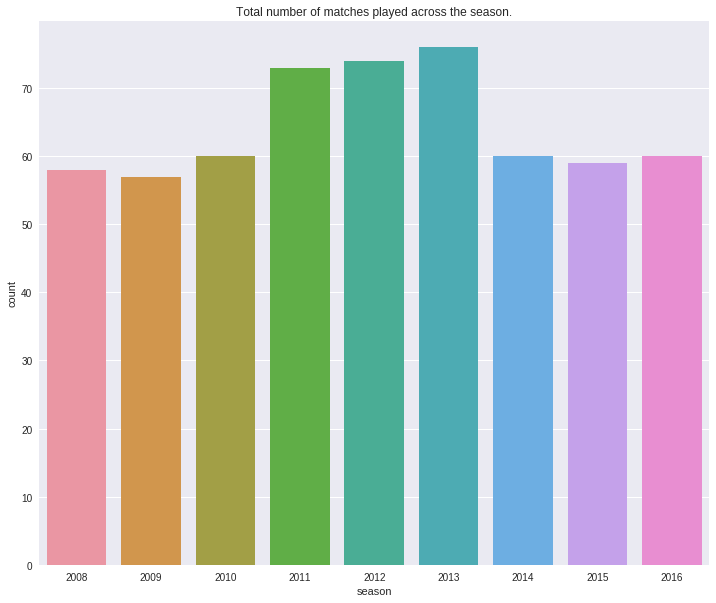

In [10]:
sns.countplot(x='season',data=matches)
plt.title('Total number of matches played across the season.')

Season 4, 5 and 6 had most matches played.

### By runs scored across the seasons

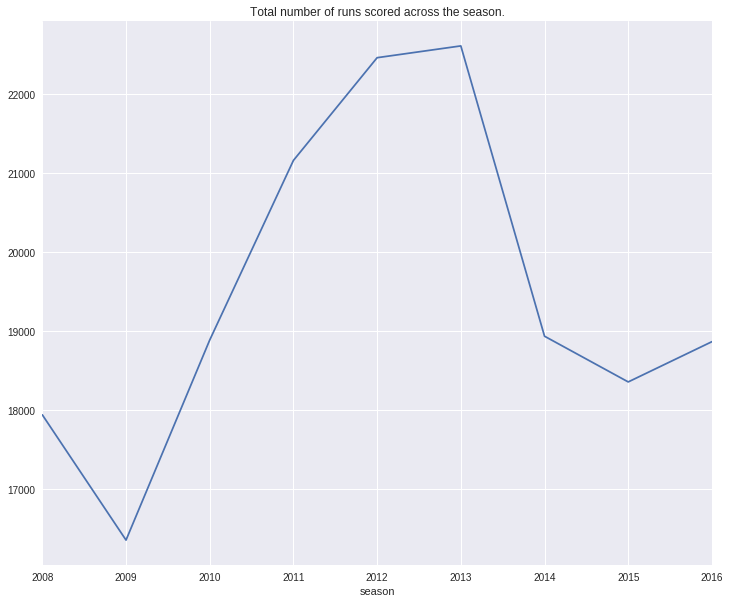

In [11]:
season=combined.groupby('season')['total_runs'].agg(sum)
season.plot()
plt.title('Total number of runs scored across the season.')

In 2013, IPL had most runs scored.

### Favourite Grounds in IPL

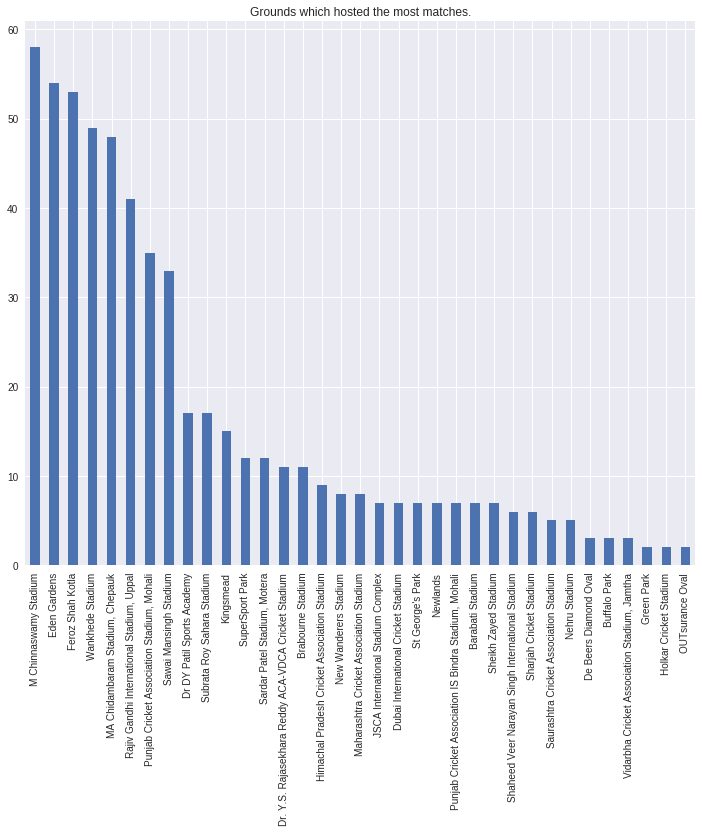

In [12]:
matches['venue'].value_counts().plot(kind='bar')
plt.title('Grounds which hosted the most matches.')

*M Chinnaswamy Stadium* held the most matches of IPl

### Get the details if the match is won by batting first

In [13]:
matches['won_batting_first']=[False]*len(matches)
for index, match in matches.iterrows():
    if match['toss_decision']=='bat':
        if match['winner']==match['toss_winner']: 
            matches.set_value(index, 'won_batting_first', True)
        else:
            matches.set_value(index, 'won_batting_first', False)
    else:
        if match['winner']==match['toss_winner']: 
            matches.set_value(index, 'won_batting_first', False)
        else: 
            matches.set_value(index, 'won_batting_first', True)

### For each venue where atleast 10 matches have been played, by batting first or second

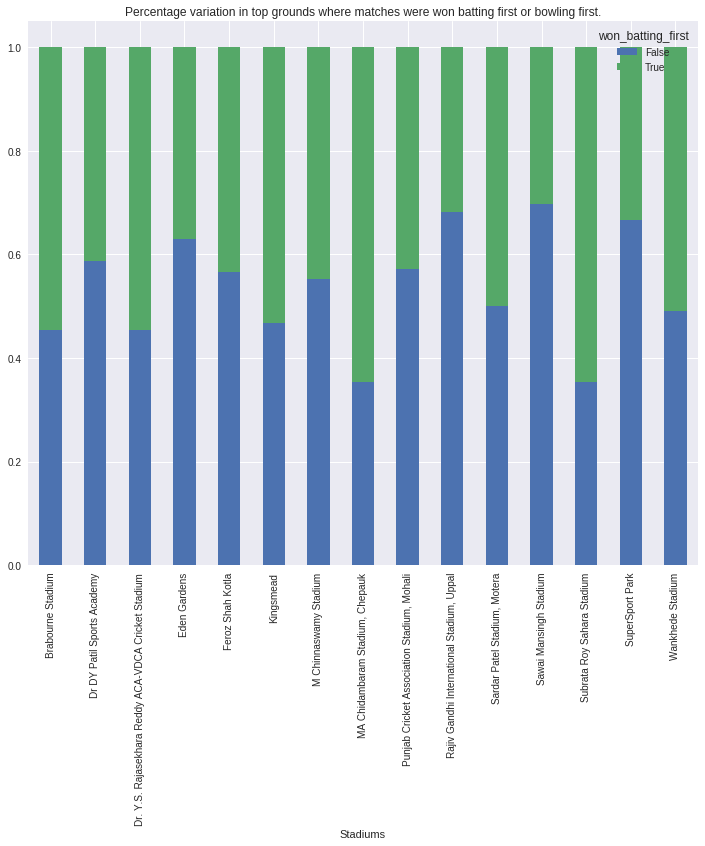

In [14]:
vc = matches.venue.value_counts() > 10
vc = vc[vc]
top_venues=matches.loc[matches.venue.isin(vc.index)]

venue=pd.crosstab(top_venues['venue'], top_venues['won_batting_first'])
venue=venue.div(venue.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
venue=plt.xlabel('Stadiums')
plt.title('Percentage variation in top grounds where matches were won batting first or bowling first.')

So we can clearly distinguish between the stadiums in which we will have more percentage of wins by batting first or batting second.

### What percentage of wins batting first across the seasons

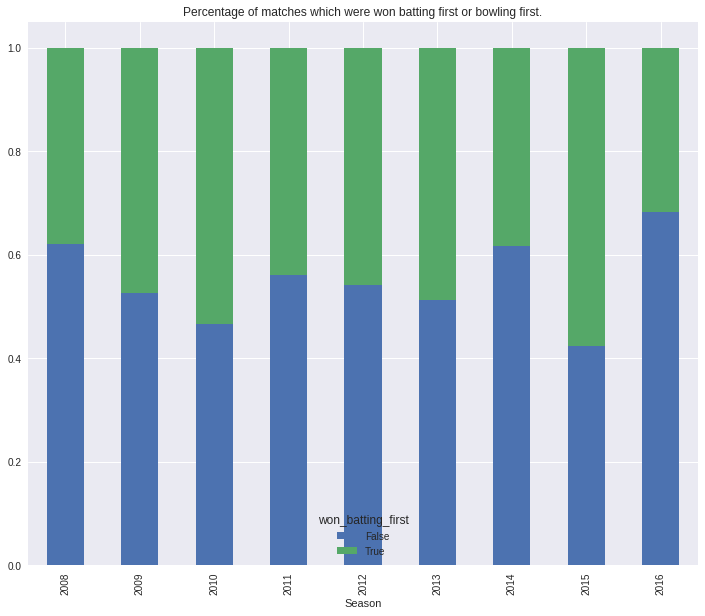

In [15]:
season=pd.crosstab(matches['season'], matches['won_batting_first'])
season=season.div(season.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
season=plt.xlabel('Season')
plt.title('Percentage of matches which were won batting first or bowling first.')

So more than 50% of the matches are lost batting first across all seasons.

### Team wins across the sesons

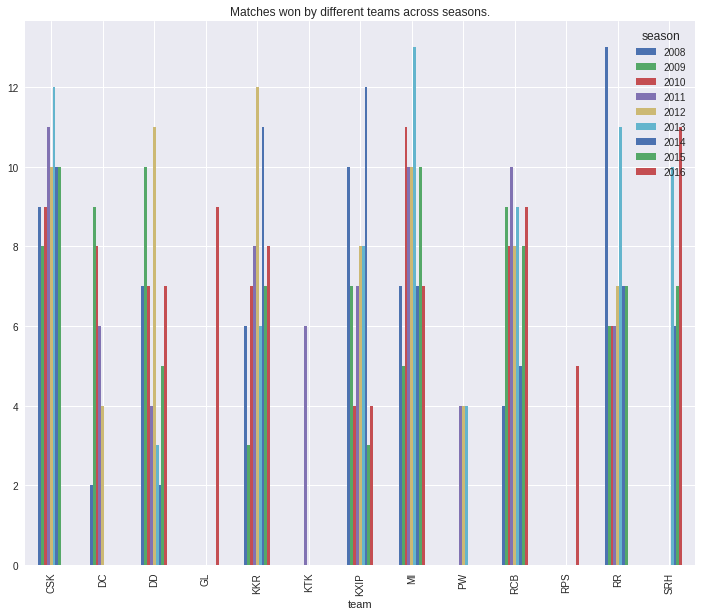

In [16]:
wins=matches.groupby(['winner', 'season'])['id'].agg('count').reset_index()
wins.columns=['team', 'season', 'wins']
wins.pivot_table(index='team', columns='season', values='wins', aggfunc=sum).plot(kind='bar')
plt.title('Matches won by different teams across seasons.')

Therefore, *CSK* had most team wins in IPL history.

### Most toss winners

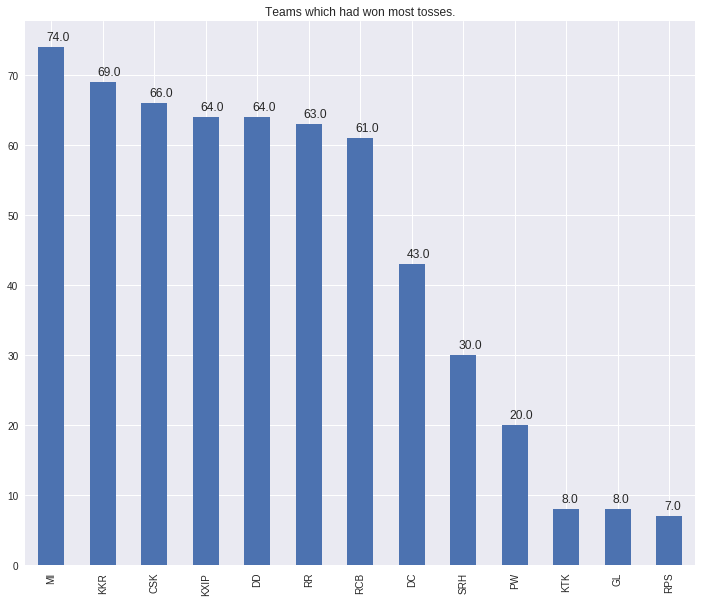

In [17]:
ax=matches['toss_winner'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.title('Teams which had won most tosses.')

MI would win the toss most of the times.

### Is toss winner also the match winner

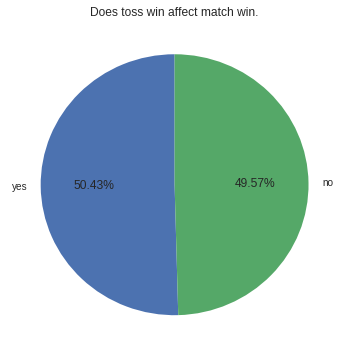

In [18]:
toss=matches[matches['toss_winner']==matches['winner']]
slices=[len(toss),(len(matches)-len(toss))]
labels=['yes','no']
plt.pie(slices,labels=labels,startangle=90,autopct='%1.2f%%')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Does toss win affect match win.')

Hence there is a 50-50 chance of team winning the toss, wins the match also.

### Team winning the toss

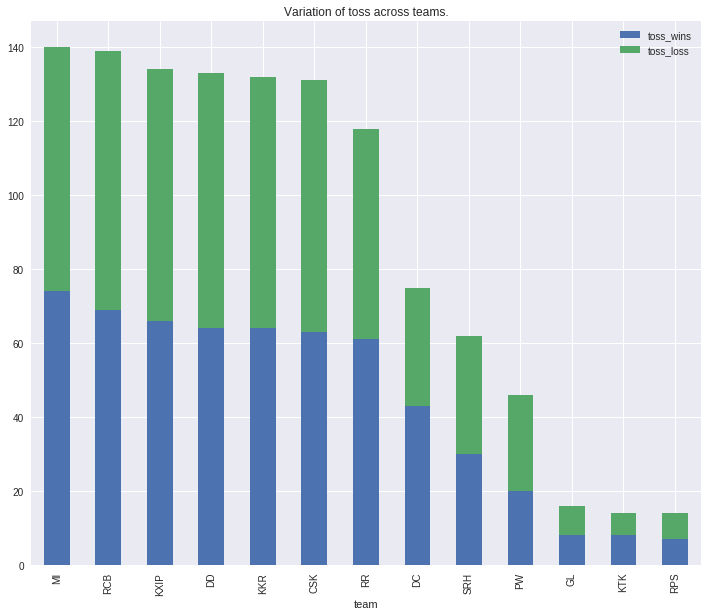

In [19]:
teams=['KKR', 'CSK', 'RR',
       'MI', 'DC', 'KXIP',
       'RCB', 'DD',
       'KTK', 'PW', 'SRH',
       'RPS', 'GL']

team=pd.concat([matches['team1'], matches['team2']]).value_counts().reset_index()
team.columns=['team', 'total matches']
team['toss_wins']=matches['toss_winner'].value_counts().reset_index()['toss_winner']
team['toss_loss']=team['total matches']-team['toss_wins']
team.plot(x='team', y=['toss_wins', 'toss_loss'], kind='bar', stacked=True)
plt.title('Variation of toss across teams.')

Its clear that *MI* played most of the matches and had most toss wins in IPL

### Teams winning matches

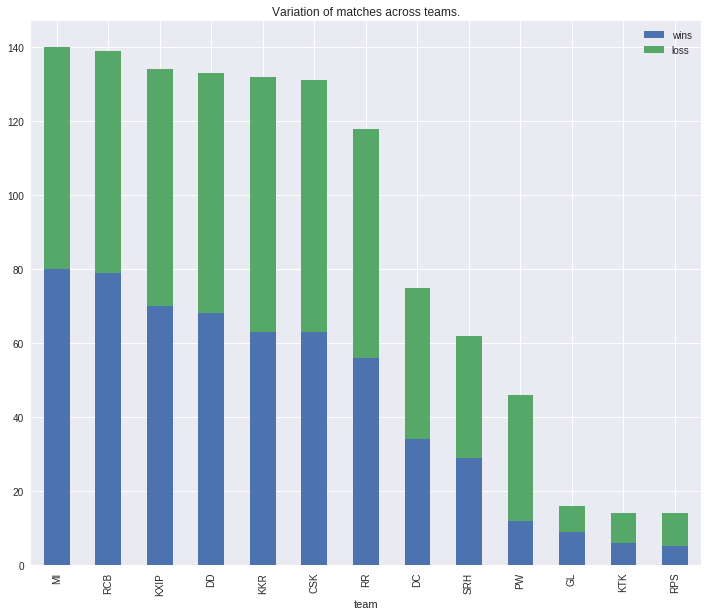

In [20]:
team['wins']=matches['winner'].value_counts().reset_index()['winner']
team['loss']=team['total matches']-team['wins']
team.plot(x='team', y=['wins', 'loss'], kind='bar', stacked=True)
plt.title('Variation of matches across teams.')

It's clear that *MI* had won most of the matches in IPL

### Average runs per match in each season

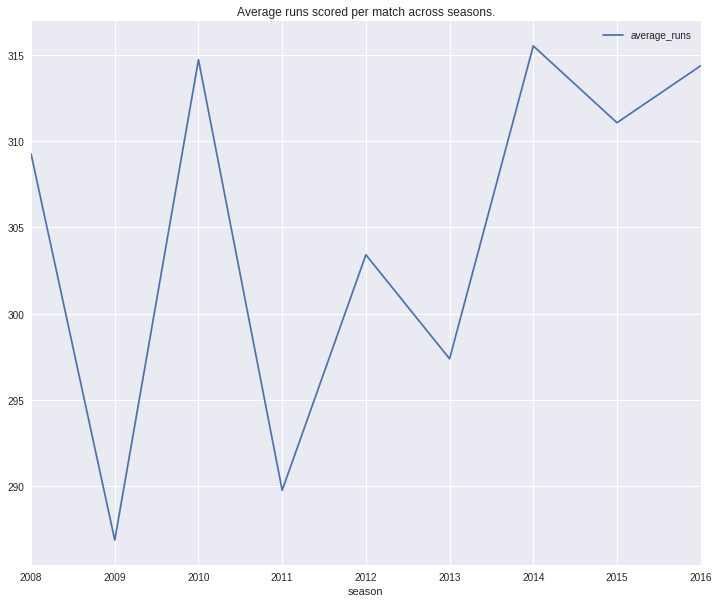

In [21]:
season=matches.groupby('season').id.count().reset_index()
season.columns=['season', 'total_matches']
season['total_runs']=combined.groupby('season')['total_runs'].agg(sum).reset_index()['total_runs']
season['average_runs']=season['total_runs']/season['total_matches']
season.plot(x='season', y='average_runs', kind='line')
plt.title('Average runs scored per match across seasons.')

On an average in 2013, most runs scored in an innings

### Maximum man of the matches

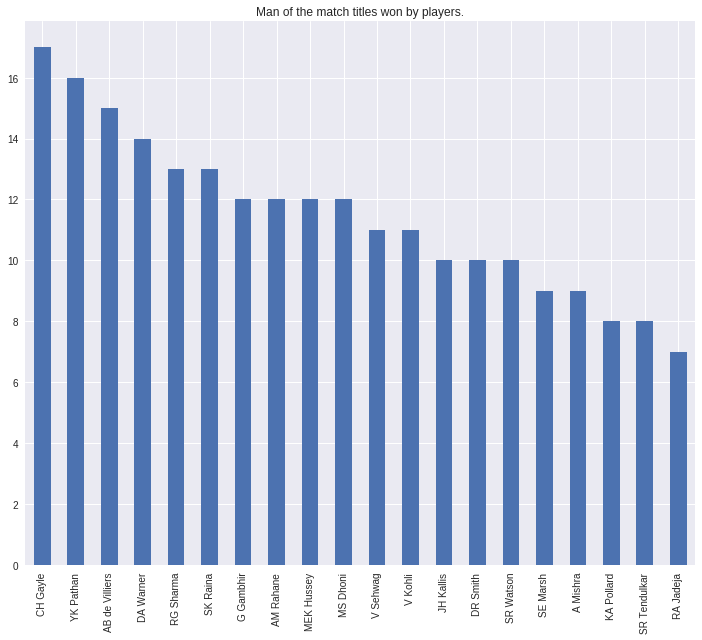

In [22]:
matches['player_of_match'].value_counts().head(20).plot(kind='bar')
plt.title('Man of the match titles won by players.')

Most 'Man of the Match' titles were won by 'CH Galye'

### Winners of IPL Championship

In [23]:
# Getting the last match of every season and finding the winner
final_matches=matches.drop_duplicates(subset='season', keep='last')
final_matches[['season', 'winner']]

,season,winner
57,2008,RR
114,2009,DC
174,2010,CSK
247,2011,CSK
321,2012,KKR
397,2013,MI
457,2014,KKR
516,2015,MI
576,2016,SRH


*CSK*, *MI* and *KKR* have won the IPL titles two times each.

### Super Overs

In [24]:
len(deliveries[deliveries['is_super_over']==1]['match_id'].unique())

6

So there are 6 matches which were decided by the super overs.

In [25]:
so=deliveries[deliveries['is_super_over']==1]['batting_team'].unique()
so

array(['KKR', 'RR', 'CSK', 'KXIP', 'SRH', 'RCB', 'DD'], dtype=object)

The above teams have played the super overs.

In [26]:
nso=list(set(teams)-set(so))
nso

['MI', 'KTK', 'DC', 'RPS', 'GL', 'PW']

The above teams have't played in super overs.

### Favourite Umpires

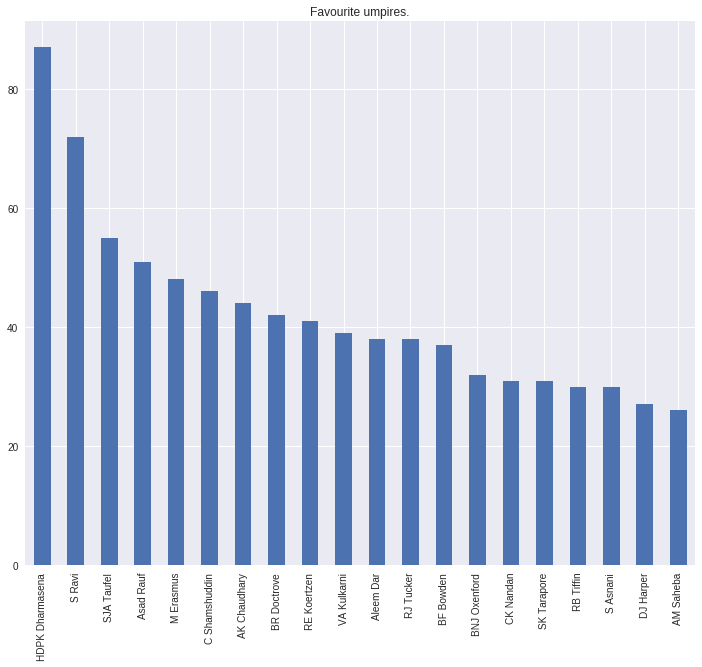

In [27]:
umpires=pd.concat([matches['umpire1'], matches['umpire2']]).value_counts().head(20)
umpires.plot(kind='bar')
plt.title('Favourite umpires.')

### Fours across the seasons

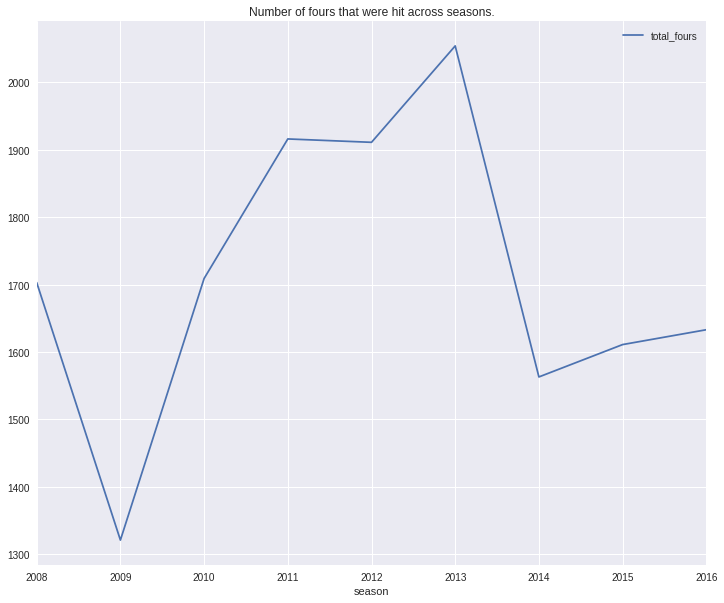

In [28]:
fours=combined[combined['batsman_runs']==4]['season'].value_counts().reset_index()
fours.columns=['season', 'total_fours']
fours=fours.sort_values('season')
fours=fours.reset_index(drop=True)
fours.plot(x='season', y='total_fours')
plt.title('Number of fours that were hit across seasons.')

In 2013, highest number of sixes were struck

### Most fours across the seasons

In [29]:
most_fours=combined[combined['batsman_runs']==4].groupby(['season', 'batsman']).id.count().reset_index()
most_fours.columns=['season', 'batsman', 'number_fours']
most_fours=most_fours.sort_values(['season', 'number_fours'], ascending=[True, False])
most_fours=most_fours.sort_values('number_fours', ascending=False)
most_fours=most_fours.drop_duplicates(subset=['season'], keep='first')
most_fours.sort_values('season')

,season,batsman,number_fours
28,2008,G Gambhir,68
176,2009,ML Hayden,60
334,2010,SR Tendulkar,86
464,2011,SR Tendulkar,67
500,2012,AM Rahane,73
683,2013,MEK Hussey,81
814,2014,RV Uthappa,74
856,2015,DA Warner,65
956,2016,DA Warner,88


### Sixes across the seasons

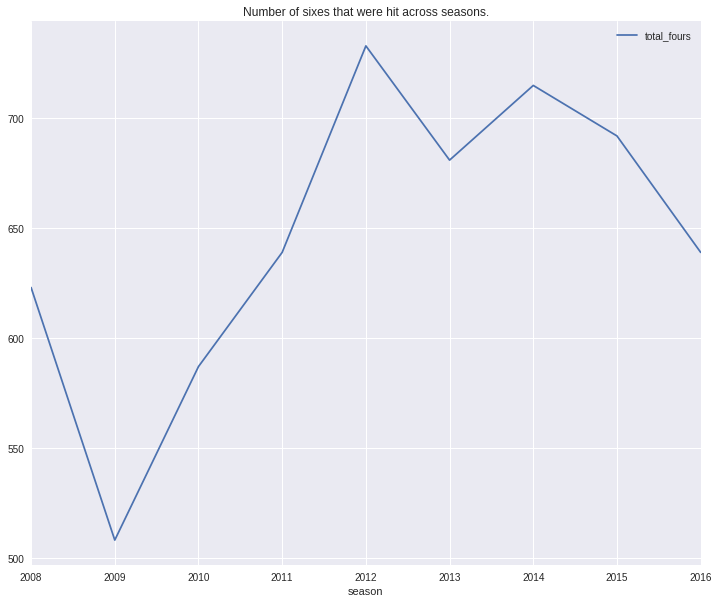

In [30]:
sixes=combined[combined['batsman_runs']==6]['season'].value_counts().reset_index()
sixes.columns=['season', 'total_fours']
sixes=sixes.sort_values('season')
sixes=sixes.reset_index(drop=True)
sixes.plot(x='season', y='total_fours')
plt.title('Number of sixes that were hit across seasons.')

In 2012, highest number of sxixes were struck.

### Most sixes across the seasons**

In [31]:
most_sixes=combined[combined['batsman_runs']==6].groupby(['season', 'batsman']).id.count().reset_index()
most_sixes.columns=['season', 'batsman', 'number_sixes']
most_sixes=most_sixes.sort_values(['season', 'number_sixes'], ascending=[True, False])
most_sixes=most_sixes.sort_values('number_sixes', ascending=False)
most_sixes=most_sixes.drop_duplicates(subset=['season'], keep='first')
most_sixes.sort_values('season')

,season,batsman,number_sixes
80,2008,ST Jayasuriya,31
102,2009,AC Gilchrist,29
245,2010,RV Uthappa,27
286,2011,CH Gayle,44
388,2012,CH Gayle,59
486,2013,CH Gayle,52
591,2014,GJ Maxwell,36
661,2015,CH Gayle,38
829,2016,V Kohli,38


*CH Gayle* has scored highest number of sixes in 4 IPL season

### Score distribution by different teams in IPL

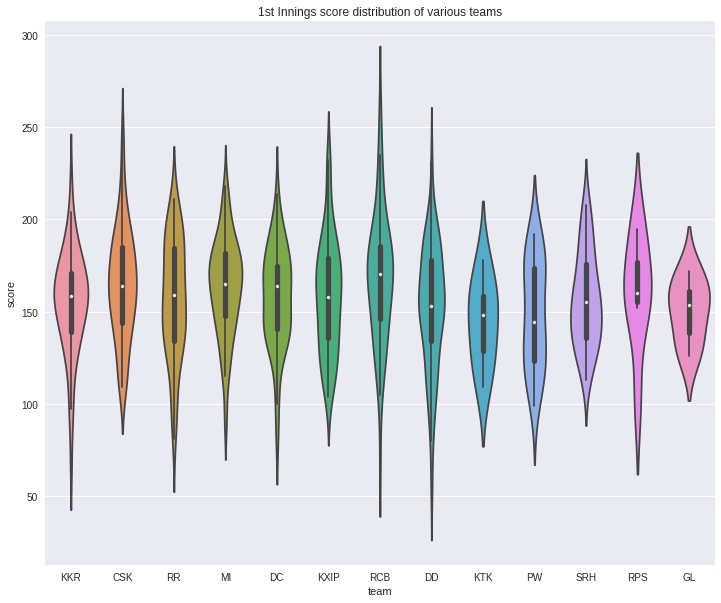

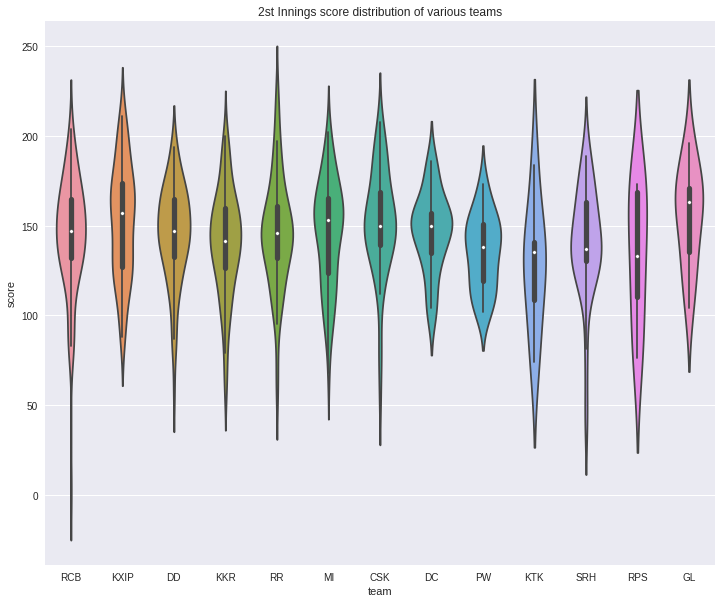

In [32]:
team_totals=deliveries.groupby(['match_id', 'batting_team', 'inning'])['total_runs'].agg(sum).reset_index()
team_totals.columns=['match_id', 'team', 'inning', 'score']
first_inning=team_totals[team_totals['inning']==1]
second_inning=team_totals[team_totals['inning']==2]
sns.violinplot(x='team', y='score', data=first_inning).set_title('1st Innings score distribution of various teams')
plt.show()
sns.violinplot(x='team', y='score', data=second_inning).set_title('2st Innings score distribution of various teams')

Team score *RCB* is less predictible as the score distribution is huge in both the inning

### Runs Scored 200+ by the batting team in an inning

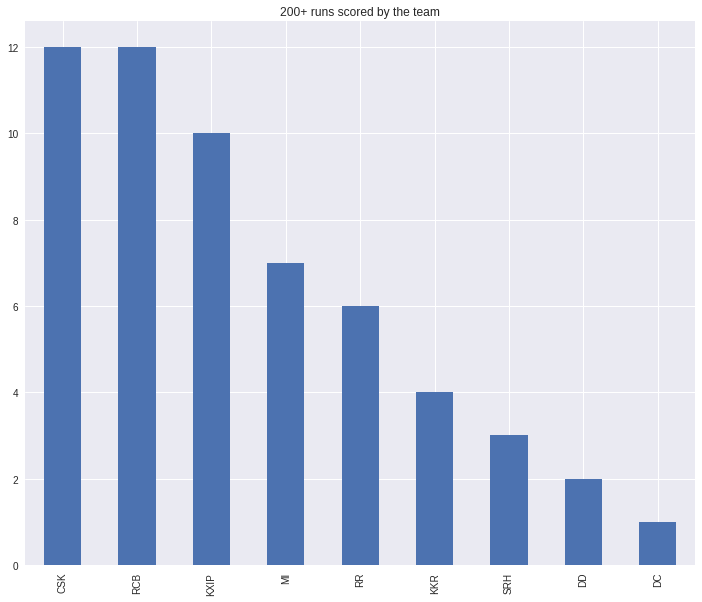

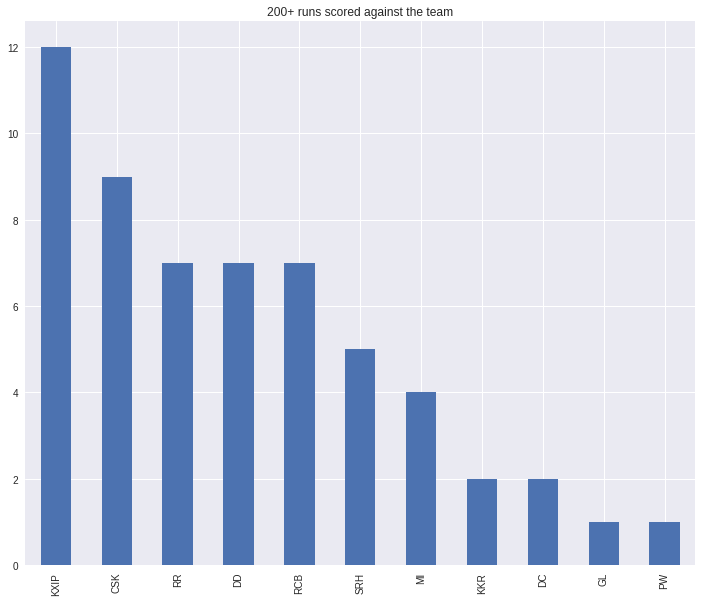

In [33]:
totals=deliveries.groupby(['match_id', 'batting_team', 'bowling_team', 'inning'])['total_runs'].agg(sum)
scores=totals.reset_index()
scores.columns=['match_id', 'batting_team', 'bowling_team', 'inning', 'score']
more_200=scores[scores['score']>=200]
more_200['batting_team'].value_counts().plot(kind='bar').set_title('200+ runs scored by the team')
plt.show()
more_200['bowling_team'].value_counts().plot(kind='bar').set_title('200+ runs scored against the team')

*RCB* has scored most number of 200+ runs.
Most number of 200+ runs was scored against *KXIP*.

### Details of the 200+ runs scored

In [34]:
more_200.groupby(['inning', 'batting_team', 'bowling_team'])['match_id'].count()

inning  batting_team  bowling_team
1       CSK           DD              1
                      KKR             1
                      KXIP            2
                      MI              1
                      RCB             1
                      RR              1
                      SRH             2
        DC            RR              1
        DD            KXIP            1
                      MI              1
        KKR           DC              1
                      KXIP            1
                      RCB             1
        KXIP          CSK             2
                      RCB             2
                      RR              1
        MI            CSK             1
                      DD              3
                      RCB             1
                      RR              1
        RCB           CSK             1
                      DD              1
                      GL              1
                      KXIP            3
     

### Number runs scored by the teams by overs

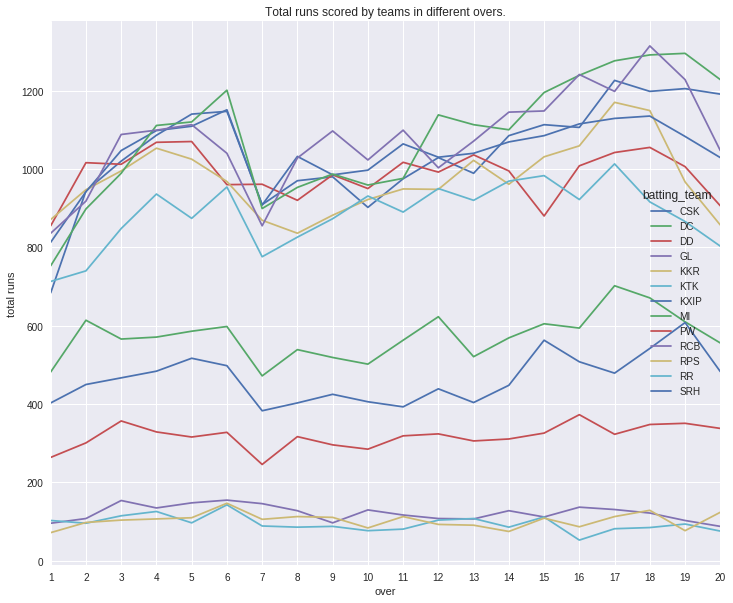

In [35]:
overs=deliveries.pivot_table(index='over', columns='batting_team', values='total_runs', aggfunc=sum)
overs.plot()
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.ylabel('total runs')
plt.title('Total runs scored by teams in different overs.')

Except *RPS*, all teams scored more runs in 17-19 overs that in 20th over.

### Is 200+ runs chased

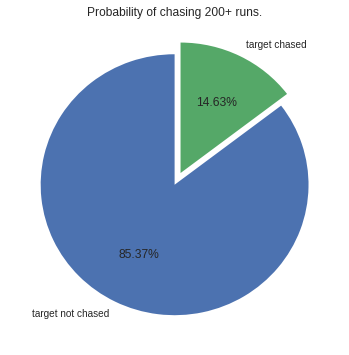

In [36]:
inning_1=more_200[more_200['inning']==1]
inning_1.columns=['match_id', 'bat_1', 'bowl_1', 'inning', 'score_1']
inning_2=scores[scores['inning']==2]
inning_2.columns=['match_id', 'bat_2', 'bowl_2', 'inning', 'score_2']
chased=pd.merge(inning_1, inning_2, left_on='match_id', right_on='match_id')
chased['chased']=chased['score_2']>chased['score_1']
slices=chased['chased'].value_counts().reset_index().chased
plt.pie(slices,labels=['target not chased','target chased'],startangle=90,explode=(0,0.1),autopct='%1.2f%%')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Probability of chasing 200+ runs.')

Most of the time 200+ terget is not chased by the chasing team.

### Top scoring batsman

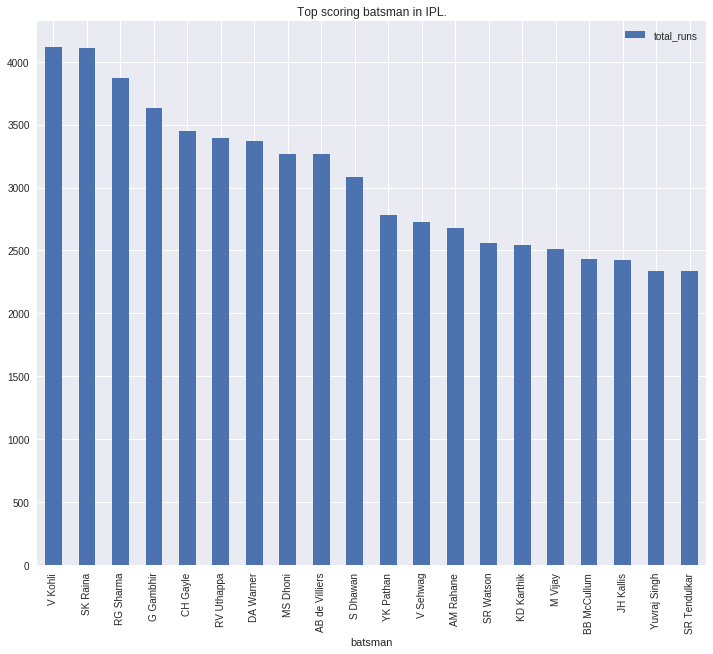

In [37]:
top_batsman=deliveries.groupby('batsman')['batsman_runs'].agg(sum).reset_index()
top_batsman.columns=['batsman', 'total_runs']
top_batsman.sort_values('total_runs', ascending=False).head(20).plot(x='batsman', y='total_runs', kind='bar')
plt.title('Top scoring batsman in IPL.')

*V Kohli* has scored most of the runs in IPL

### Top batsmans with 1's, 2's, 3's and 6's

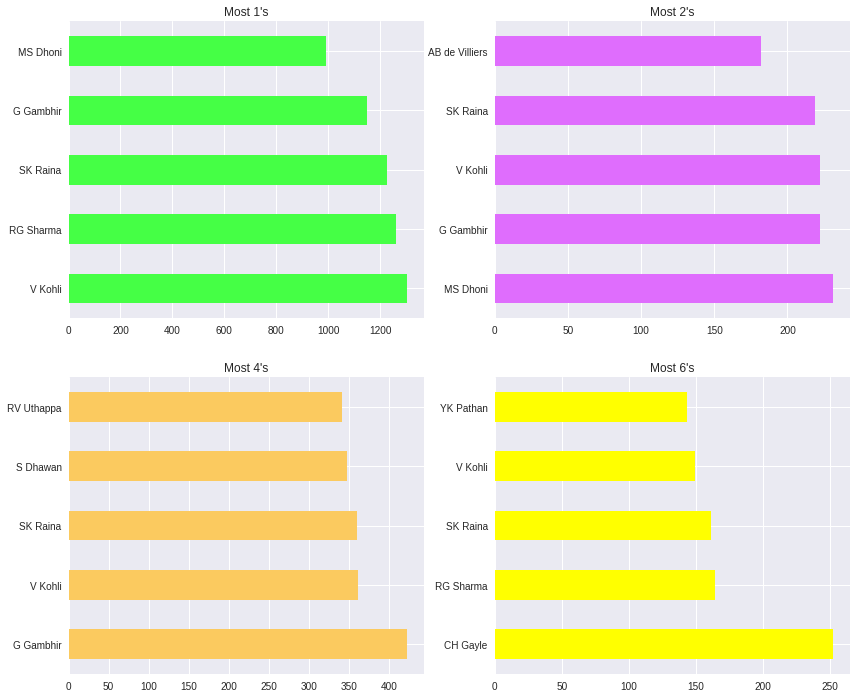

In [38]:
toppers=deliveries.groupby(['batsman', 'batsman_runs'])['total_runs'].count().reset_index()
toppers=toppers.pivot('batsman','batsman_runs', 'total_runs')
toppersfig,ax=plt.subplots(2,2,figsize=(14,12))
toppers[1].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[0,0],color='#45ff45')
ax[0,0].set_title("Most 1's")
ax[0,0].set_ylabel('')
toppers[2].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[0,1],color='#df6dfd')
ax[0,1].set_title("Most 2's")
ax[0,1].set_ylabel('')
toppers[4].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[1,0],color='#fbca5f')
ax[1,0].set_title("Most 4's")
ax[1,0].set_ylabel('')
toppers[6].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[1,1],color='#ffff00')
ax[1,1].set_title("Most 6's")
ax[1,1].set_ylabel('')
plt.show()

### Top 20 individual scores in IPL

In [39]:
top_scores=deliveries.groupby(['match_id', 'batsman', 'batting_team', 'bowling_team'])['batsman_runs'].agg(sum).reset_index()
top_scores.sort_values('batsman_runs', ascending=False).head(20)

,match_id,batsman,batting_team,bowling_team,batsman_runs
5302,352,CH Gayle,RCB,PW,175
2,1,BB McCullum,KKR,RCB,158
7528,503,AB de Villiers,RCB,MI,133
8359,561,AB de Villiers,RCB,GL,129
4687,313,CH Gayle,RCB,DD,128
2237,147,M Vijay,CSK,RR,127
6854,457,V Sehwag,KXIP,CSK,122
2788,184,PC Valthaty,KXIP,CSK,120
3325,220,V Sehwag,DD,DC,119
7460,498,CH Gayle,RCB,KXIP,117


### Score distribution of top batsman

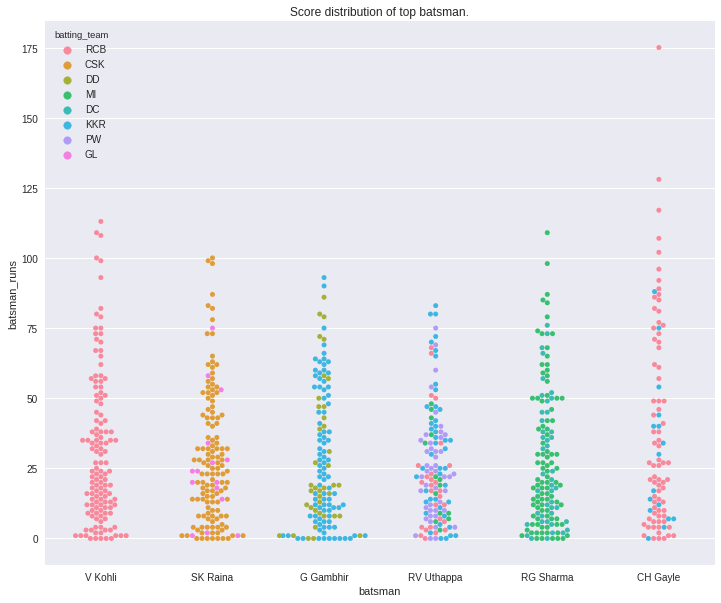

In [40]:
top_scorers=top_batsman.sort_values('total_runs', ascending=False).head(6)
scores=deliveries.groupby(['match_id', 'batsman', 'batting_team'])['batsman_runs'].sum().reset_index()
scores=scores[scores['batsman'].isin(top_scorers['batsman'])]
sns.swarmplot(x='batsman', y='batsman_runs', hue='batting_team', data=scores)
plt.title('Score distribution of top batsman.')

*CH Gayle* has most centuries in IPL.
*G Gambir* and *RV Uthappa* don't have centuries in IPL

### Runs scored by top batsman across seasons

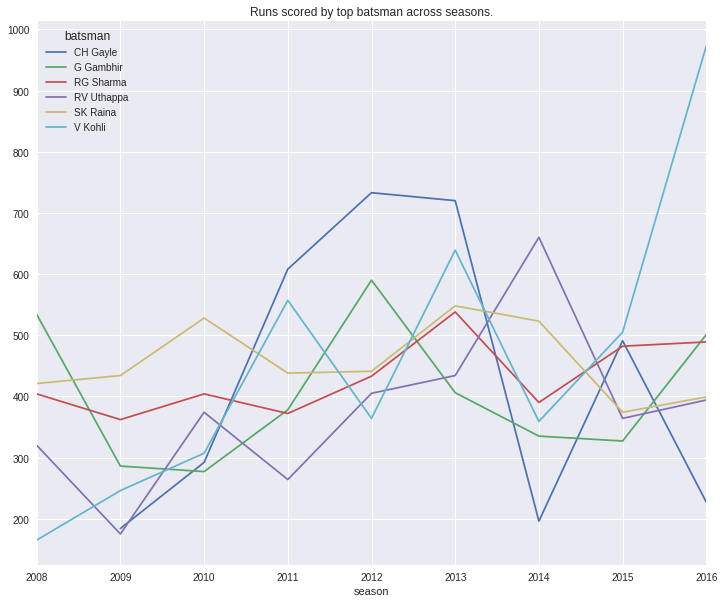

In [41]:
scores=combined.groupby(['season', 'batsman'])['batsman_runs'].sum().reset_index()
scores=scores[scores['batsman'].isin(top_scorers['batsman'])]
scores.pivot_table(index='season', columns='batsman', values='batsman_runs', aggfunc=sum).plot()
plt.title('Runs scored by top batsman across seasons.')

From 2013, *CH Gayle* is not in the form. And from 2014, *V Kolhi* is in better form than ever.

### Different ways of scoring by top batsman

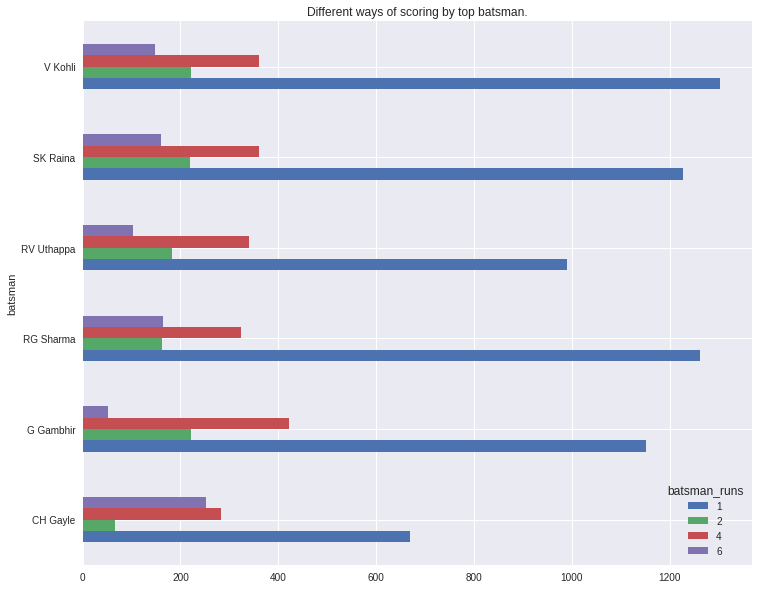

In [42]:
scores=deliveries.groupby(['batsman', 'batsman_runs'])['total_runs'].count().reset_index()
scores=scores[scores['batsman'].isin(top_scorers['batsman'])]
scores=scores[(scores['batsman_runs']!=0)&(scores['batsman_runs']!=3)&(scores['batsman_runs']!=5)]
scores.pivot_table(index='batsman', columns='batsman_runs', values='total_runs', aggfunc=sum).plot(kind='barh')
plt.title('Different ways of scoring by top batsman.')

*V Kolhi* has scored more singles, *G Gambir* deals most of the time in 4's. And of course *CH Gayle* in sixes.

### Ways by which top batsman are dismissed

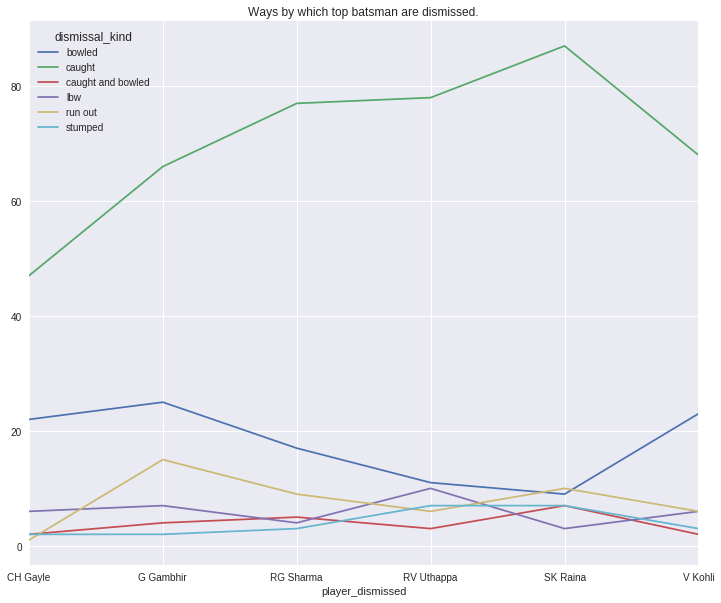

In [43]:
top_dismissals=deliveries[deliveries['player_dismissed'].isin(top_scorers['batsman'])]
top_dismissals=top_dismissals.groupby(['player_dismissed', 'dismissal_kind'])['match_id'].count().reset_index()
top_dismissals.pivot_table(index='player_dismissed', columns='dismissal_kind', values='match_id', aggfunc=sum).plot()
plt.title('Ways by which top batsman are dismissed.')

Most of the top batsmans are dissmissed by catches than any other wickets.

### Top batsman are most vulnerable which bowler

In [44]:
top_dismissals=deliveries[deliveries['player_dismissed'].isin(top_scorers['batsman'])]
top_dismissals=top_dismissals[top_dismissals['dismissal_kind'].isin(['caught','lbw','bowled','stumped','caught and bowled','hit wicket'])]
top_dismissals=top_dismissals.groupby(['batsman', 'bowler'])['match_id'].count().reset_index()
top_dismissals.columns=['batsman', 'bolwer', 'no_of_dismissals']
top_dismissals=top_dismissals.sort_values('no_of_dismissals', ascending=False)
top_dismissals=top_dismissals.drop_duplicates(subset=['batsman'], keep='first')
top_dismissals.sort_values('batsman')

,batsman,bolwer,no_of_dismissals
34,CH Gayle,R Ashwin,4
123,G Gambhir,Z Khan,5
174,RG Sharma,R Vinay Kumar,6
193,RV Uthappa,A Mishra,4
279,SK Raina,Harbhajan Singh,4
339,V Kohli,A Nehra,6


Top batsman should be aware of the respective bowlers.

### Orange caps for the season goes to which player

In [45]:
orange=combined.groupby(['season', 'batsman', 'batting_team'])['batsman_runs'].sum().reset_index()
orange=orange.sort_values('batsman_runs', ascending=False)
orange=orange.drop_duplicates(subset=["season"],keep="first")
orange.sort_values(by='season')

,season,batsman,batting_team,batsman_runs
115,2008,SE Marsh,Kings XI Punjab,616
229,2009,ML Hayden,Chennai Super Kings,572
446,2010,SR Tendulkar,Mumbai Indians,618
502,2011,CH Gayle,Royal Challengers Bangalore,608
684,2012,CH Gayle,Royal Challengers Bangalore,733
910,2013,MEK Hussey,Chennai Super Kings,733
1088,2014,RV Uthappa,Kolkata Knight Riders,660
1148,2015,DA Warner,Sunrisers Hyderabad,562
1383,2016,V Kohli,Royal Challengers Bangalore,973


**Frequency distribution of individual scores**

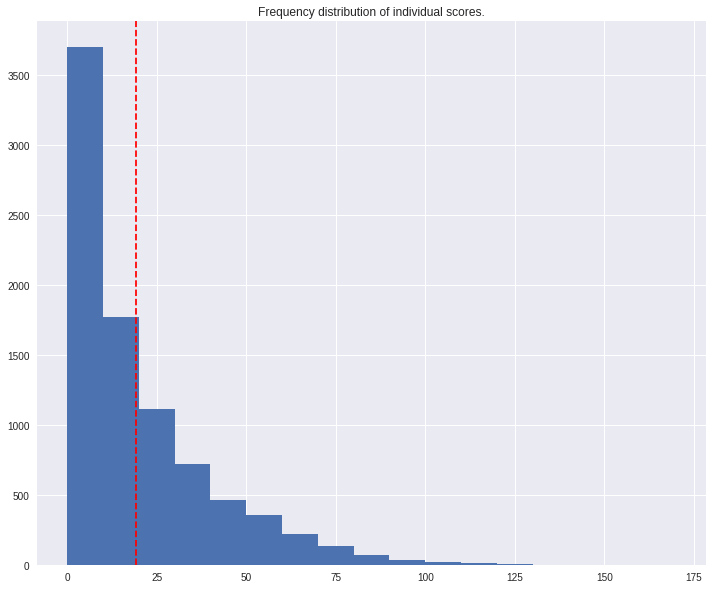

In [46]:
top_scores.hist(column='batsman_runs', bins=range(0,180,10))
plt.axvline(top_scores['batsman_runs'].mean(), color='r', linestyle='dashed')
plt.title('Frequency distribution of individual scores.')

Average runs by a batsman is around 20 in IPL history.

### Most wickets taken by a bowler in IPL

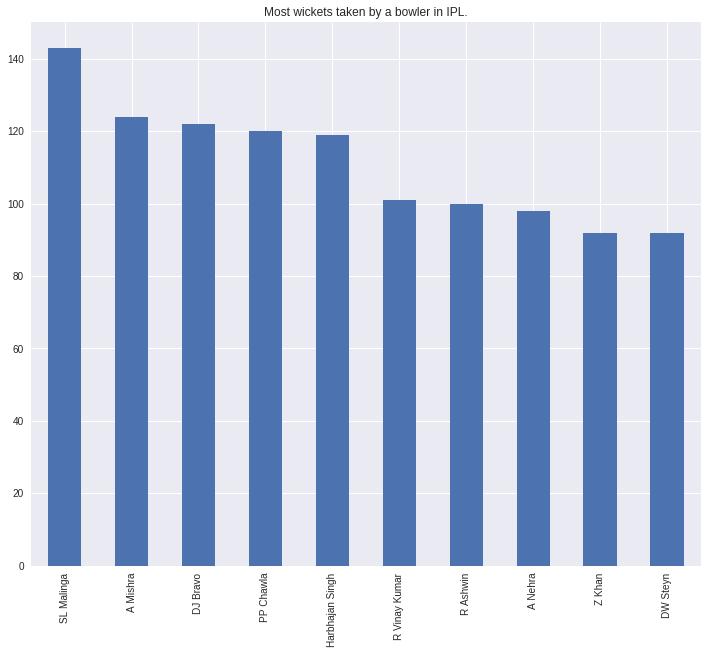

In [47]:
dismissal_kinds = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
most_wickets=deliveries[deliveries['dismissal_kind'].isin(dismissal_kinds)]
most_wickets['bowler'].value_counts().head(10).plot(kind='bar')
plt.title('Most wickets taken by a bowler in IPL.')

*SL Malinga* has most wickets taken in IPL history.

### Most overs bowled by any bowler

In [48]:
most_overs=deliveries.groupby('bowler').agg({'match_id':'count', 'total_runs':'sum'})
most_overs.columns=['total_balls', 'total_runs']
most_overs=most_overs.reset_index()
most_overs['total_overs']=most_overs['total_balls']//6
most_overs=most_overs.sort_values('total_overs', ascending=False)
most_overs.head(10)

,bowler,total_balls,total_runs,total_overs
109,Harbhajan Singh,2742,3184,457
203,P Kumar,2529,3188,421
214,PP Chawla,2472,3136,412
4,A Mishra,2466,2960,411
276,SL Malinga,2407,2646,401
219,R Ashwin,2359,2552,393
95,DW Steyn,2159,2375,359
229,R Vinay Kumar,2141,2945,356
80,DJ Bravo,2110,2815,351
114,IK Pathan,2101,2685,350


### Economy of the bowlers with 300+ overs in IPL

In [49]:
most_overs['economy']=most_overs['total_runs']/most_overs['total_overs']
most_overs=most_overs.sort_values('economy')
most_overs[most_overs['total_overs']>=300]

,bowler,total_balls,total_runs,total_overs,economy
219,R Ashwin,2359,2552,393,6.493639
276,SL Malinga,2407,2646,401,6.598504
95,DW Steyn,2159,2375,359,6.615599
109,Harbhajan Singh,2742,3184,457,6.967177
4,A Mishra,2466,2960,411,7.201946
215,PP Ojha,1945,2399,324,7.404321
333,Z Khan,2030,2537,338,7.505917
203,P Kumar,2529,3188,421,7.572447
214,PP Chawla,2472,3136,412,7.611650
6,A Nehra,1842,2339,307,7.618893


*R Ashwin* has better economy among top bowlers.

### Frequency distribution of the economy of bowlers

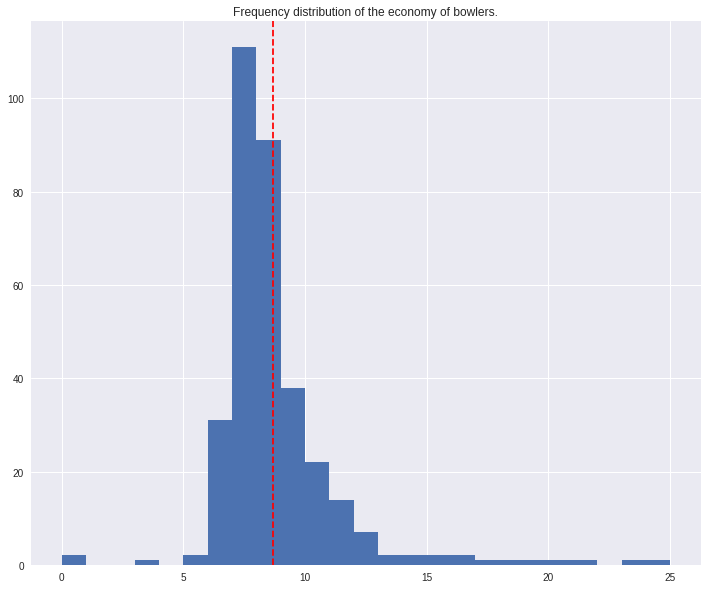

In [50]:
most_overs=most_overs.replace([np.inf, -np.inf], np.nan)
most_overs=most_overs.fillna(0)
most_overs.hist(column='economy', bins=range(0,26))
plt.axvline(most_overs['economy'].mean(), color='r', linestyle='dashed')
plt.title('Frequency distribution of the economy of bowlers.')

Average economy of a bowler is between 8 and 9 in IPL

### Purple cap for the season goes to which bowler

In [51]:
dismissal_kinds = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
dismissals=combined[deliveries['dismissal_kind'].isin(dismissal_kinds)]
top_wickets=dismissals.groupby(['season', 'bowler'])['match_id'].count().reset_index()
top_wickets.columns=['season', 'bowler', 'wickets']
top_wickets=top_wickets.sort_values('wickets', ascending=False)
top_wickets=top_wickets.drop_duplicates(subset=['season'], keep='first')
top_wickets.sort_values('season')

,season,bowler,wickets
75,2008,Sohail Tanvir,22
152,2009,RP Singh,23
241,2010,PP Ojha,21
367,2011,SL Malinga,28
437,2012,M Morkel,25
509,2013,DJ Bravo,32
638,2014,MM Sharma,23
694,2015,DJ Bravo,26
773,2016,B Kumar,23


### Most common extras given in IPL

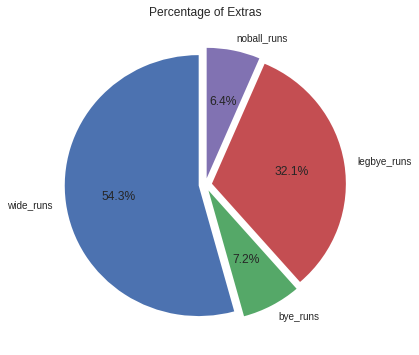

In [52]:
extras=deliveries[['wide_runs','bye_runs','legbye_runs','noball_runs']].sum()
plt.pie(extras, labels=['wide_runs','bye_runs','legbye_runs','noball_runs'],explode=(0.05,0.05,0.05,0.05),autopct='%1.1f%%', startangle=90)
plt.title("Percentage of Extras")
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.plot()
plt.show()

54.3% of extra runs comes from wides.

### Most common dismissals in IPL

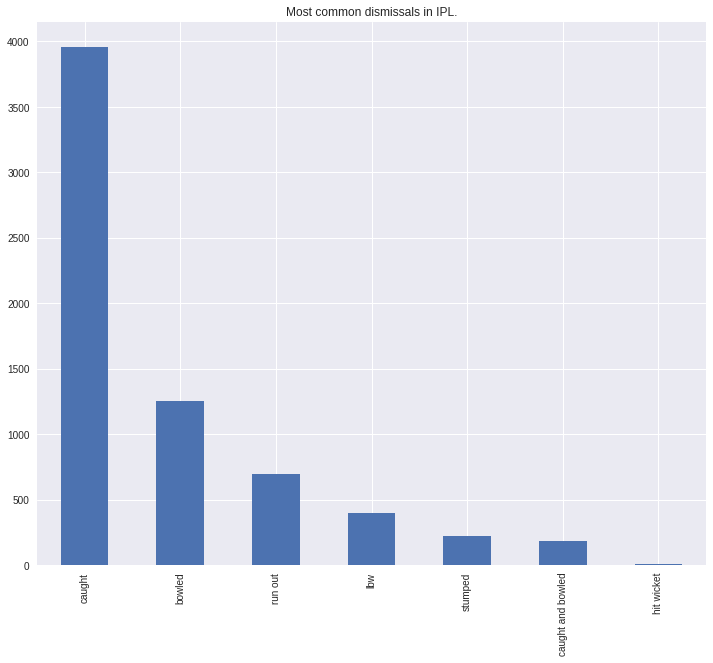

In [53]:
dismissal_kinds=["run out","bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
dismissals=deliveries[deliveries["dismissal_kind"].isin(dismissal_kinds)]
dismissals['dismissal_kind'].value_counts().plot(kind='bar')
plt.title('Most common dismissals in IPL.')

Catch is the most common dismissal of a batsman.

### Most sixes by a team in IPL

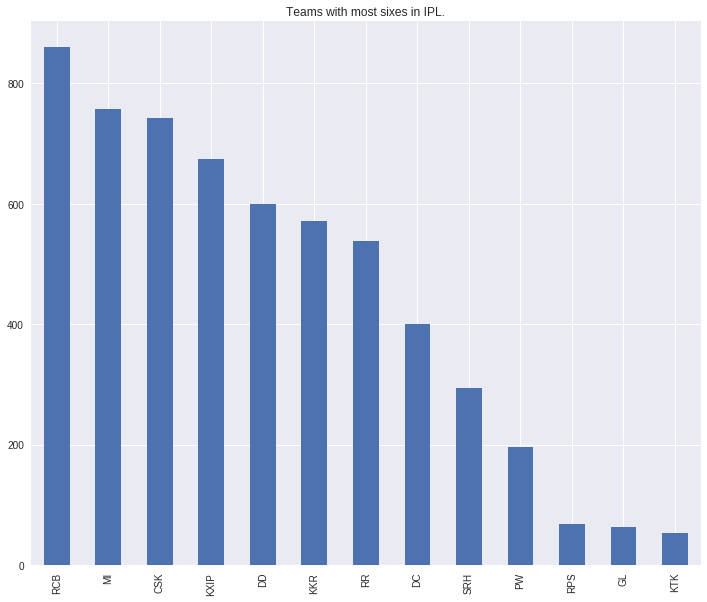

In [54]:
sixes=deliveries[deliveries['batsman_runs']==6]
sixes['batting_team'].value_counts().plot(kind='bar')
plt.title('Teams with most sixes in IPL.')

*RCB* hold the record of most sixes in IPL

### Most finalists team and most team which won the final

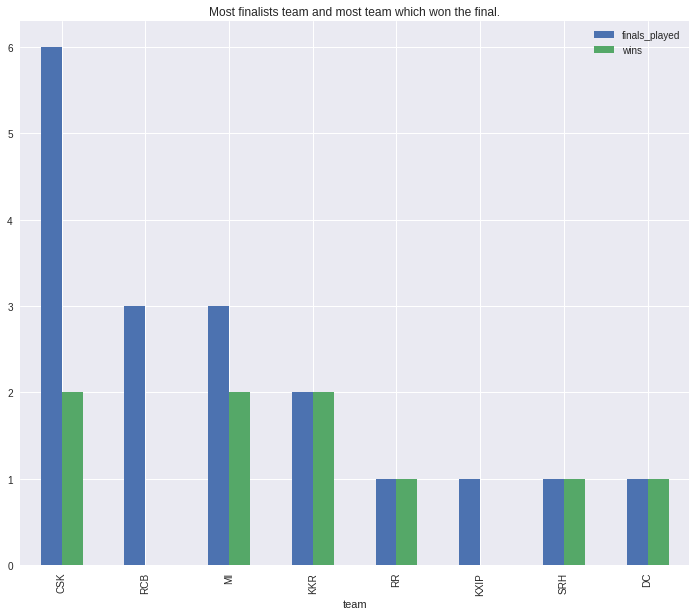

In [55]:
final_matches=matches.drop_duplicates(subset='season', keep='last')
most_finalists=pd.concat([final_matches['team1'], final_matches['team2']]).value_counts().reset_index()
most_finalists.columns=['team', 'finals_played']
most_final_wins=final_matches['winner'].value_counts().reset_index()
most_final_wins.columns=['team', 'wins']
df=pd.merge(most_finalists, most_final_wins, left_on='team', right_on='team', how='outer')
df.plot(kind='bar', x='team', y=['finals_played', 'wins'])
plt.title('Most finalists team and most team which won the final.')

*CSK*, *MI* and *KKR* have won IPL 2 times. But *CSK* has a better channce of entering the IPL final.

### Importance of toss in a final match

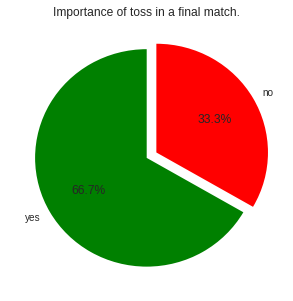

In [56]:
tw_mw=final_matches[final_matches['toss_winner']==final_matches['winner']]
slices=[len(tw_mw), len(final_matches)-len(tw_mw)]
plt.pie(slices,labels=['yes', 'no'],startangle=90,colors=['G','R'],explode=(0,0.1),autopct='%1.1f%%')
plt.title('Importance of toss in a final match.')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

Team which wins the toss in IPL final match, wins the match by 66.7% of the times.

### Toss decission made in a final match

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


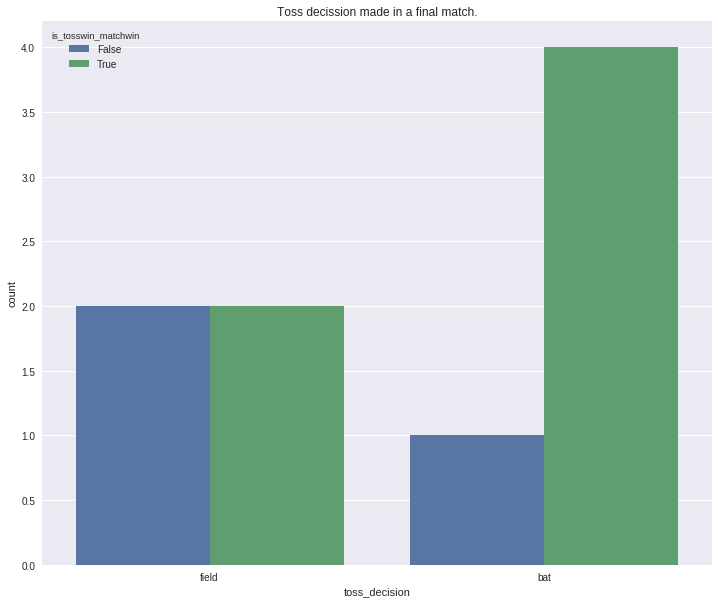

In [57]:
final_matches['is_tosswin_matchwin']=final_matches['toss_winner']==final_matches['winner']
sns.countplot(x='toss_decision',hue='is_tosswin_matchwin',data=final_matches)
plt.title('Toss decission made in a final match.')

Most of the time, team winning the toss and choosing to bat in IPL final wins the IPL tournament.